In [21]:
import numpy as np
import pandas as pd
import string
import random
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Black-Scholes: Are Returns Normal?

In [22]:
!pip install --upgrade pandas-datareader
from pandas_datareader import data

Requirement already up-to-date: pandas-datareader in /opt/anaconda3/lib/python3.8/site-packages (0.9.0)


In [48]:
# import price data
price = data.DataReader("SPY", 
                       start='2000-1-01', 
                       end='2019-12-31', 
                       data_source='yahoo')
# import dividend data
divs = data.DataReader('SPY', 
                       'yahoo-dividends',
                       start='2000-1-01', 
                       end='2019-12-31')

print(price.head())
print('-----')
print(divs.head())

                 High         Low       Open     Close      Volume  Adj Close
Date                                                                         
2000-01-03  148.25000  143.875000  148.25000  145.4375   8164300.0  98.146072
2000-01-04  144.06250  139.640625  143.53125  139.7500   8089800.0  94.307983
2000-01-05  141.53125  137.250000  139.93750  140.0000  12177900.0  94.476685
2000-01-06  141.50000  137.750000  139.62500  137.7500   6227200.0  92.958336
2000-01-07  145.75000  140.062500  140.31250  145.7500   8066500.0  98.356987
-----
              action  value
2019-12-20  DIVIDEND  1.570
2019-09-20  DIVIDEND  1.384
2019-06-21  DIVIDEND  1.432
2019-03-15  DIVIDEND  1.233
2018-12-21  DIVIDEND  1.435


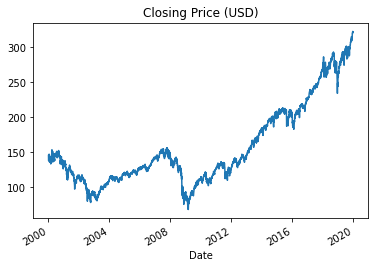

In [49]:
# plot price data over time
price['Close'].plot.line(title='Closing Price (USD)')
plt.savefig('spy_price_plot.png')

In [50]:
# merge dataframes
df = price.join(divs)
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close',
                      'action'], axis=1)

# fill in no dividend days with zeros
df['value'] = df['value'].fillna(0)
df.columns = ['close', 'div']


# calculate return  
df['previous close'] = df['close'].shift(periods=1, fill_value=np.nan)
df['return'] = (df['close'] - df['previous close'] + 
                df['div'])/df['previous close']

# drop the first row (cant calculate return from previous close)
df = df.dropna(subset=['return'])
df

,close,div,previous close,return
Date,,,,
2000-01-04,139.750000,0.0,145.437500,-0.039106
2000-01-05,140.000000,0.0,139.750000,0.001789
2000-01-06,137.750000,0.0,140.000000,-0.016071
2000-01-07,145.750000,0.0,137.750000,0.058076
2000-01-10,146.250000,0.0,145.750000,0.003431
...,...,...,...,...
2019-12-24,321.230011,0.0,321.220001,0.000031
2019-12-26,322.940002,0.0,321.230011,0.005323
2019-12-27,322.859985,0.0,322.940002,-0.000248


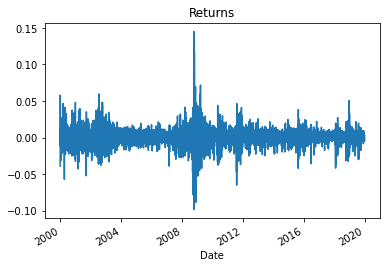

In [51]:
# plot returns over time
df['return'].plot.line(title='Returns')
plt.savefig('spy_returns_plot.png')

In [52]:
# sort the data by returns
dfsorted = df.sort_values(by=['return'])
dfsorted

,close,div,previous close,return
Date,,,,
2008-10-15,90.019997,0.0,99.849998,-0.098448
2008-12-01,82.110001,0.0,90.089996,-0.088578
2008-09-29,111.379997,0.0,120.849998,-0.078362
2008-11-20,75.449997,0.0,81.500000,-0.074233
2008-10-09,90.699997,0.0,97.510002,-0.069839
...,...,...,...,...
2008-11-13,91.169998,0.0,85.820000,0.062340
2008-11-24,85.029999,0.0,79.519997,0.069291
2009-03-23,82.220001,0.0,76.709999,0.071829


In [53]:
# calculate the cdf
print(dfsorted.count())
dfsorted['N'] = np.arange(len(dfsorted))
dfsorted['cdf'] = dfsorted['N'] /(5030+1)
dfsorted

close             5030
div               5030
previous close    5030
return            5030
dtype: int64


,close,div,previous close,return,N,cdf
Date,,,,,,
2008-10-15,90.019997,0.0,99.849998,-0.098448,0,0.000000
2008-12-01,82.110001,0.0,90.089996,-0.088578,1,0.000199
2008-09-29,111.379997,0.0,120.849998,-0.078362,2,0.000398
2008-11-20,75.449997,0.0,81.500000,-0.074233,3,0.000596
2008-10-09,90.699997,0.0,97.510002,-0.069839,4,0.000795
...,...,...,...,...,...,...
2008-11-13,91.169998,0.0,85.820000,0.062340,5025,0.998807
2008-11-24,85.029999,0.0,79.519997,0.069291,5026,0.999006
2009-03-23,82.220001,0.0,76.709999,0.071829,5027,0.999205


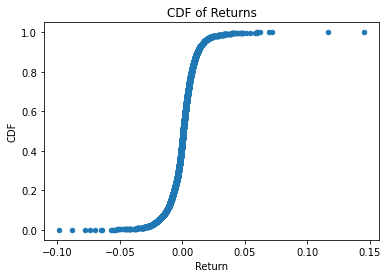

In [54]:
# plot the cdf scatter 
ax = dfsorted.plot.scatter(x='return', y='cdf', title='CDF of Returns')
plt.ylabel('CDF')
plt.xlabel('Return')
plt.savefig('spy_cdf_plot.png')

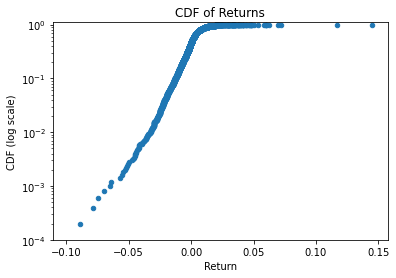

In [55]:
# plot the cdf scatter 
# using log scale
ax = dfsorted.plot.scatter(x='return', y='cdf', logy=True, ylim=(.0001,1.1), title='CDF of Returns')
plt.ylabel('CDF (log scale)')
plt.xlabel('Return')
plt.savefig('spy_cdf_log_plot.png')

In [56]:
# calculate the 1-cdf
dfsorted['1-cdf'] = 1-dfsorted['cdf']

# cdf is return is negative, and 1-cdf if return is positive
dfsorted.loc[df['return']>0, 'cdf, 1-cdf'] = dfsorted['1-cdf']
dfsorted.loc[df['return']<=0, 'cdf, 1-cdf'] = dfsorted['cdf']

dfsorted

,close,div,previous close,return,N,cdf,1-cdf,"cdf, 1-cdf"
Date,,,,,,,,
2008-10-15,90.019997,0.0,99.849998,-0.098448,0,0.000000,1.000000,0.000000
2008-12-01,82.110001,0.0,90.089996,-0.088578,1,0.000199,0.999801,0.000199
2008-09-29,111.379997,0.0,120.849998,-0.078362,2,0.000398,0.999602,0.000398
2008-11-20,75.449997,0.0,81.500000,-0.074233,3,0.000596,0.999404,0.000596
2008-10-09,90.699997,0.0,97.510002,-0.069839,4,0.000795,0.999205,0.000795
...,...,...,...,...,...,...,...,...
2008-11-13,91.169998,0.0,85.820000,0.062340,5025,0.998807,0.001193,0.001193
2008-11-24,85.029999,0.0,79.519997,0.069291,5026,0.999006,0.000994,0.000994
2009-03-23,82.220001,0.0,76.709999,0.071829,5027,0.999205,0.000795,0.000795


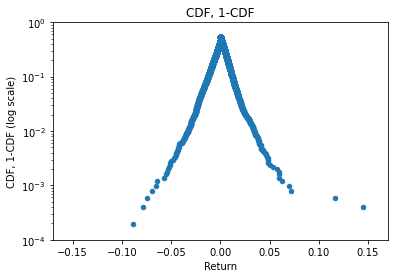

In [57]:
# plot the cdf, 1-cdf scatter 
# using log scale
ax = dfsorted.plot.scatter(x='return', y='cdf, 1-cdf', logy=True, 
                      xlim=(-.17, .17), ylim=(.0001,1), title='CDF, 1-CDF')
plt.ylabel('CDF, 1-CDF (log scale)')
plt.xlabel('Return')
plt.savefig('spy_cdf_1minus_log_plot.png')

In [58]:
# calculate mean and std
print(dfsorted['return'].mean())
print(dfsorted['return'].std())

0.000303831290834255
0.01194892004685354


In [59]:
# calculate the cdf, 1-cdf, and both
dfsorted['norm_cdf'] = norm.cdf(dfsorted['return'], loc=0.0003, scale =.0119)
dfsorted['1-norm_cdf'] = 1-dfsorted['norm_cdf']

dfsorted.loc[df['return']>0, 'norm_cdf, 1-norm_cdf'] = dfsorted['1-norm_cdf']
dfsorted.loc[df['return']<0, 'norm_cdf, 1-norm_cdf'] = dfsorted['norm_cdf']

dfsorted[['norm_cdf', '1-norm_cdf', 'norm_cdf, 1-norm_cdf', 'return']]

,norm_cdf,1-norm_cdf,"norm_cdf, 1-norm_cdf",return
Date,,,,
2008-10-15,5.288354e-17,1.000000e+00,5.288354e-17,-0.098448
2008-12-01,4.048217e-14,1.000000e+00,4.048217e-14,-0.088578
2008-09-29,1.918748e-11,1.000000e+00,1.918748e-11,-0.078362
2008-11-20,1.884678e-10,1.000000e+00,1.884678e-10,-0.074233
2008-10-09,1.884361e-09,1.000000e+00,1.884361e-09,-0.069839
...,...,...,...,...
2008-11-13,9.999999e-01,9.269250e-08,9.269250e-08,0.062340
2008-11-24,1.000000e+00,3.364655e-09,3.364655e-09,0.069291
2009-03-23,1.000000e+00,9.228229e-10,9.228229e-10,0.071829


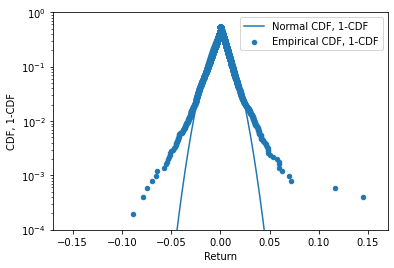

In [60]:
ax = dfsorted.plot.scatter(x='return', y=['cdf, 1-cdf'], logy=True, 
                      xlim=(-.17, .17), ylim=(.0001,1))

dfsorted.plot.line(x='return', y=['norm_cdf, 1-norm_cdf'], logy=True, 
                      xlim=(-.17, .17), ylim=(.0001,1), ax=ax)

ax.legend(['Normal CDF, 1-CDF', 'Empirical CDF, 1-CDF'])
plt.ylabel('CDF, 1-CDF')
plt.xlabel('Return')
plt.savefig('spy_cdfs_and_normal_plot.png')

The center of the return distribution is roughly normally distributed. However, the tails are not. The normal distribution underpredicts the liklihood of days with very high or very low returns.